# Analysing Real-World Datasets and Training on those

In [1]:
import numpy as np
import random
from tqdm.notebook import tqdm
from copy import deepcopy
import time
import torch
import torch.nn as nn 
import torch.nn.functional as F
import pytorch_lightning as pl
pl.seed_everything(42)

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.reset_orig()

Global seed set to 42


In [2]:
from graph_discovery import GraphDiscoveryMatrix
from utils import matrix_to_order
from causal_graphs.graph_real_world import load_graph_file
from causal_graphs.graph_generation import generate_categorical_graph, generate_chain, generate_random_graph
from causal_graphs.graph_visualization import visualize_graph
from causal_graphs.graph_utils import adj_matrix_to_edges

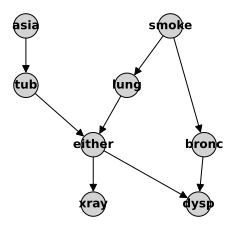

CausalDAG with 8 variables [asia,tub,smoke,lung,bronc,either,xray,dysp] and 8 edges:
asia => tub
tub => either
smoke => lung,bronc
lung => either
bronc => dysp
either => xray,dysp



In [3]:
graph = load_graph_file('../causal_graphs/real_data/asia.bif')
visualize_graph(graph, show_plot=True, figsize=(3,3))
print(graph)

In [4]:
discovery_module = GraphDiscoveryMatrix(graph=graph, model_iters=1000, lambda_sparse=0.0001, batch_size=4096, lr_permut=5e-3, lr_model=5e-3,
                                        order_grads_opt='weight_expect_no_denom_weight_intervention', edge_grads_opt='weight_expect',
                                        N_s=1, C_s=200, max_graph_stacking=20)
discovery_module.to(torch.device("cuda:0"))

In [5]:
for _ in range(0):
    discovery_module.model_fitting_step()

In [6]:
if graph.num_vars == 2:
    inp = torch.LongTensor([[0,0],
                            [1,0]])
    mask = torch.zeros(inp.shape[-1], inp.shape[-1])
    mask[0,1] = 1
    mask[1,0] = 1
    inp = inp.to("cuda:0")
    mask = mask.to("cuda:0")
    out = discovery_module.fittingModule.model(inp, mask)
    out = out[:,1]
    print(torch.softmax(out, dim=-1))

In [7]:
if graph.num_vars == 5:
    inp = torch.LongTensor([[0,0,0,0,0],
                            [0,1,0,0,0],
                            [1,0,0,0,0],
                            [1,1,0,0,0]])
    mask = torch.FloatTensor([[0,0,1,0,0],
                              [0,0,1,0,0],
                              [1,1,0,0,0],
                              [0,0,0,0,0],
                              [0,0,0,0,0]])
    mask = mask[None].expand(inp.shape[0],-1,-1)
    inp = inp.to("cuda:0")
    mask = mask.to("cuda:0")
    out = discovery_module.fittingModule.model(inp, mask)
    out = out[:,2]
    print(torch.softmax(out, dim=-1))

In [8]:
if graph.num_vars == 8:
    inp = torch.LongTensor([[0,0,0,0,0,0,0,0],
                            [1,0,0,0,0,0,0,0]])
    mask = torch.zeros(inp.shape[-1], inp.shape[-1])
    mask[0,1] = 1
    mask[1,0] = 1
    inp = inp.to("cuda:0")
    mask = mask.to("cuda:0")
    out = discovery_module.fittingModule.model(inp, mask)
    out = out[:,1]
    print(torch.softmax(out, dim=-1))

tensor([[0.5511, 0.4489],
        [0.5384, 0.4616]], device='cuda:0', grad_fn=<SoftmaxBackward>)


In [9]:
discovery_module.discover_graph(num_epochs=1)

Gamma - Recall: 100.00%, Precision: 33.33% (TP=8,FP=16,FN=0,TN=32)
Theta - Direction accuracy: 100.00% (TP=8,FN=0) / Soft accuracy: 100.00% (TP=8,FN=0)


Parameter containing:
tensor([[-9.0000e+15,  1.7573e-01,  1.0248e-01,  8.6596e-02, -9.8538e-03,
          1.8792e-02, -1.6052e-02,  3.0059e-02],
        [-1.6241e-01, -9.0000e+15, -5.5546e-02,  8.8624e-02,  1.1709e-02,
          3.3357e-01,  2.0793e-01,  2.7763e-02],
        [-3.6571e-01, -5.5479e-02, -9.0000e+15,  3.3413e-01,  4.0522e-01,
          3.5102e-02,  1.9889e-02,  2.5030e-02],
        [-3.6434e-01,  1.2618e-01,  2.6713e-01, -9.0000e+15, -2.6778e-02,
          3.2443e-01,  2.6055e-01,  1.0151e-01],
        [-3.6297e-01, -3.0806e-02,  3.1439e-01,  4.2171e-02, -9.0000e+15,
         -6.3386e-02,  3.4745e-02,  4.4023e-01],
        [-3.8048e-01,  1.4346e-01, -4.3041e-02,  1.3980e-01,  9.0394e-02,
         -9.0000e+15,  4.1471e-01,  3.1517e-01],
        [-3.9038e-01,  5.6812e-02, -1.6234e-01,  3.1123e-02,  5.0434e-02,
          2.9435e-01, -9.0000e+15,  1.7857e-01],
        [-4.1043e-01, -3.9571e-02,  1.1816e-02, -5.2500e-02,  2.9874e-01,
          1.3019e-01,  5.7370e-02, -9.0000e

In [10]:
discovery_module.gamma

Parameter containing:
tensor([[-9.0000e+15,  1.7573e-01,  1.0248e-01,  8.6596e-02, -9.8538e-03,
          1.8792e-02, -1.6052e-02,  3.0059e-02],
        [-1.6241e-01, -9.0000e+15, -5.5546e-02,  8.8624e-02,  1.1709e-02,
          3.3357e-01,  2.0793e-01,  2.7763e-02],
        [-3.6571e-01, -5.5479e-02, -9.0000e+15,  3.3413e-01,  4.0522e-01,
          3.5102e-02,  1.9889e-02,  2.5030e-02],
        [-3.6434e-01,  1.2618e-01,  2.6713e-01, -9.0000e+15, -2.6778e-02,
          3.2443e-01,  2.6055e-01,  1.0151e-01],
        [-3.6297e-01, -3.0806e-02,  3.1439e-01,  4.2171e-02, -9.0000e+15,
         -6.3386e-02,  3.4745e-02,  4.4023e-01],
        [-3.8048e-01,  1.4346e-01, -4.3041e-02,  1.3980e-01,  9.0394e-02,
         -9.0000e+15,  4.1471e-01,  3.1517e-01],
        [-3.9038e-01,  5.6812e-02, -1.6234e-01,  3.1123e-02,  5.0434e-02,
          2.9435e-01, -9.0000e+15,  1.7857e-01],
        [-4.1043e-01, -3.9571e-02,  1.1816e-02, -5.2500e-02,  2.9874e-01,
          1.3019e-01,  5.7370e-02, -9.0000e

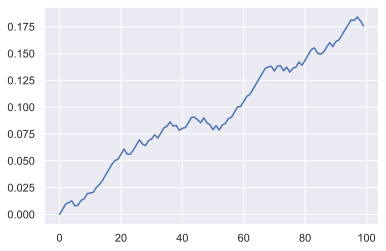

In [11]:
sns.set()
gamma_log = torch.stack(discovery_module.gamma_log, dim=0)
edge_log = gamma_log[:,0,1]
plt.plot(edge_log.numpy())
plt.show()

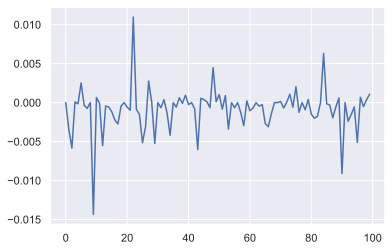

In [15]:
sns.set()
gamma_grad_log = torch.stack(discovery_module.gamma_grad_log, dim=0)
edge_grad_log = gamma_grad_log[:,0,1]
plt.plot(edge_grad_log.numpy())
plt.show()

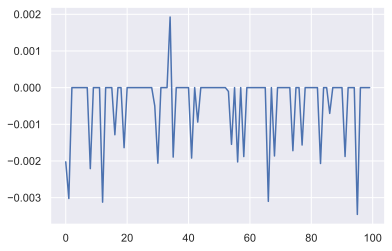

In [16]:
sns.set()
theta_matrix_grad_log = torch.stack(discovery_module.theta_matrix_grad_log, dim=0)
theta_grad_log = theta_matrix_grad_log[:,0,1]
plt.plot(theta_grad_log.numpy())
plt.show()

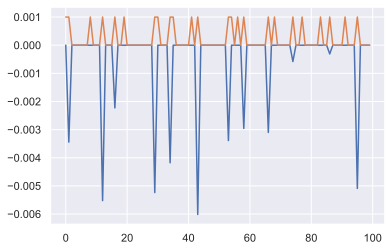

In [18]:
sns.set()
masked_grads = (theta_grad_log != 0).float() * edge_grad_log
plt.plot(masked_grads.numpy())
plt.plot((theta_grad_log != 0).float().numpy() * 0.001)
plt.show()